<a href="https://colab.research.google.com/github/YersonQuispe/Modelos-ML-Pagos/blob/main/Modelo_de_Probabilidad_de_Pago_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MODELO DE SCORE DE CONTACTABILIDAD

Yerson Alexander Quispe

# **2.2 Random Forest**

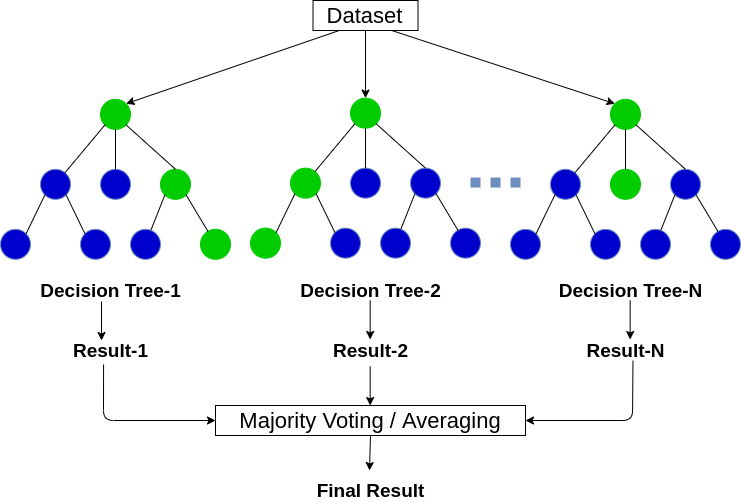

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
PATH = 'gdrive/MyDrive/DataSet/'

df = pd.read_excel(PATH + 'DataSetBalanceado.xlsx')

In [ ]:
print(df.head())
print(df.info())
print(df.describe())


  DesTipoDoc  CodCliente    NroDoc  CodEntidad           DesEntidad  \
0        DNI     2345340  10119396        1005  FINANCIERA EFECTIVA   
1        DNI     1501172  70255191        1004            INTERBANK   
2        DNI     1505794  76469751        1004            INTERBANK   
3        DNI     2276686  43652281        1004            INTERBANK   
4        DNI     2312683  29390807        1005  FINANCIERA EFECTIVA   

   CodCartera DesCartera        NroCuenta  CodProducto DesProducto  ...  \
0        1009    CASTIGO  1141456-1325877         1018     CASTIGO  ...   
1        1008    CASTIGO         47386092         1017     CASTIGO  ...   
2        1008    CASTIGO         47408562         1017     CASTIGO  ...   
3        1008    CASTIGO         47550211         1017     CASTIGO  ...   
4        1009    CASTIGO  1228528-1510005         1018     CASTIGO  ...   

   EJEC_PDP_EXC  PDP_VIG MontoPDPVigente PDP_CAI  ncliente  \
0             0        0               0       1       NaN  

In [ ]:
df['PagoRealizado'] = df['NroPagos'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
# Definir las variables predictoras
features = [
    'Edad', 'MacroRegiones', 'DeudaCapital',
    'RCC','AÑO_CASTIGO', 'MES_CASTIGO', 'Campaña', 'Maduracion'
]

In [ ]:
# Preprocesamiento
df['SituacionLaboral'] = df['SituacionLaboral'].map({
    'DEPENDIENTE': 1,
    'INDEPENDIENTE': 2,
    'INFORMAL': 3
})
df['MacroRegiones'] = df['MacroRegiones'].map({
    'ZONA NORTE': 1,
    'ZONA SUR': 2,
    'ZONA CENTRO': 3,
    'OTROS': 4
})
df['ProductoAgrupado'] = df['ProductoAgrupado'].apply(lambda x: 1 if x == 'MULTIPRODUCTO' else 0)

df['RangoEdad'] = df['RangoEdad'].replace({
    "01.[18-25]": 21,
    "02.[26-35]": 30,
    "03.[36-45]": 40,
    "04.[46-55]": 50,
    "05.[56-65]": 60,
    "06.[66-+>": 70
})
df['EstadoCuenta'] = df['EstadoCuenta'].apply(lambda x: 1 if x == 'Gestionado' else 0)
df['FlagCuentaNueva'] = df['FlagCuentaNueva'].apply(lambda x: 1 if x == 'S' else 0)

df['CDH'] = df['CDH'].apply(lambda x: 1 if x == 'S' else 0)
# Convertir 'RCC' a numérico, asignando un valor específico a 'SIN INFORMACION'
df['RCC'] = pd.to_numeric(df['RCC'], errors='coerce')

# Reemplazar 'SIN INFORMACION' con un valor especial, por ejemplo, la mediana
df['RCC'].fillna(df['RCC'].median(), inplace=True)

df["FechaRegistroCuenta"] = pd.to_datetime(df["FechaRegistroCuenta"], format="%Y-%m", errors='coerce')
# Convertir la columna 'FechaRegistroCuenta' a tipo datetime
df['FechaRegistroCuenta'] = df['FechaRegistroCuenta'].dt.year


<ipython-input-7-aae61d349088>:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['RCC'].fillna(df['RCC'].median(), inplace=True)


In [ ]:
# Eliminar filas con valores nulos
df_clean = df.dropna(subset=features + ['PagoRealizado'])

In [ ]:
# Separar X e y
X = df_clean[features]
y = df_clean['PagoRealizado']

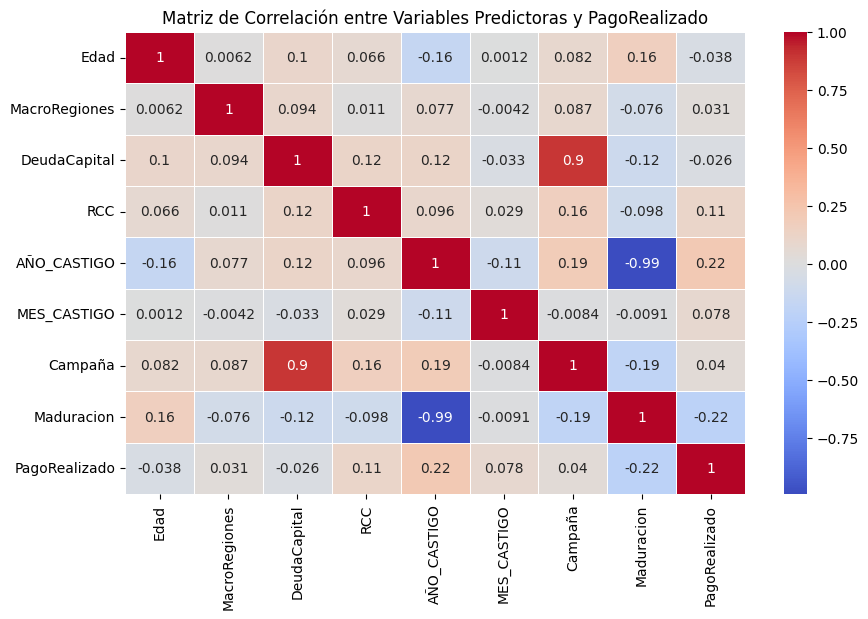

In [ ]:
# Crear matriz de correlación solo con variables numéricas
plt.figure(figsize=(10,6))
df_numeric = df[features + ["PagoRealizado"]]  # Agregamos CD_binario
sns.heatmap(df_numeric.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlación entre Variables Predictoras y PagoRealizado")
plt.show()

In [ ]:
# Crear la matriz de correlación
corr_matrix = df_numeric.corr()

# Extraer la correlación con CD_binario y ordenarla de mayor a menor
corr_with_cd = corr_matrix["PagoRealizado"].sort_values(ascending=False)

# Imprimir los resultados
print("Correlaciones con PagoRealizado (orden descendente):\n")
print(corr_with_cd)

Correlaciones con PagoRealizado (orden descendente):

PagoRealizado    1.000000
AÑO_CASTIGO      0.219569
RCC              0.106499
MES_CASTIGO      0.078080
Campaña          0.039568
MacroRegiones    0.030734
DeudaCapital    -0.026229
Edad            -0.037735
Maduracion      -0.215017
Name: PagoRealizado, dtype: float64


Rojo oscuro (cercano a 1): Correlación fuerte y positiva (cuando una variable aumenta, la otra también). // Azul oscuro (cercano a -1): Correlación fuerte y negativa (cuando una variable aumenta, la otra disminuye). Blanco Azul claro (cercano a 0): No hay correlación significativa.

In [ ]:
# Dividir datos en entrenamiento (75%) y prueba (25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=5)

In [ ]:
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV

In [ ]:
# Validación cruzada con Repeated K-Fold
rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)


In [ ]:
# Definir hiperparámetros para GridSearchCV
paramGridRF = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

In [ ]:
# Entrenar modelo con ajuste de hiperparámetros
modelo_rf = GridSearchCV(RandomForestClassifier(class_weight='balanced'), paramGridRF, cv=rkf, n_jobs=-1, verbose=2)
modelo_rf.fit(X_train, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


GridSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=1),
             estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20], 'min_samples_leaf': [2, 4],
                         'min_samples_split': [5, 10],
                         'n_estimators': [50, 100]},
             verbose=2)

In [ ]:
# Mejor modelo encontrado
best_modelR = modelo_rf.best_estimator_

In [ ]:
# Predicciones
pred_train = best_modelR.predict(X_train)
pred_test = best_modelR.predict(X_test)

In [ ]:
# Evaluación del modelo
print("Train Accuracy:", accuracy_score(y_train, pred_train))
print("Tasa de Error en Train: {:.2f}".format(1 - accuracy_score(y_train, pred_train)))
print("Test Accuracy:", accuracy_score(y_test, pred_test))
print("Tasa de Error en Test: {:.2f}".format(1 - accuracy_score(y_test, pred_test)))
print("\nReporte de Clasificación en Test Set:")
print(classification_report(y_test, pred_test))

Train Accuracy: 0.9198931909212283
Tasa de Error en Train: 0.08
Test Accuracy: 0.7190661478599222
Tasa de Error en Test: 0.28

Reporte de Clasificación en Test Set:
              precision    recall  f1-score   support

           0       0.72      0.73      0.73       658
           1       0.72      0.70      0.71       627

    accuracy                           0.72      1285
   macro avg       0.72      0.72      0.72      1285
weighted avg       0.72      0.72      0.72      1285



In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier

In [ ]:
# Balanceo con Random Undersampling
undersample = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersample.fit_resample(X, y)

In [ ]:
# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=5)

In [ ]:
# Validación cruzada con Repeated K-Fold
rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)

In [ ]:
# Definir hiperparámetros para RandomizedSearchCV
paramGridXGB = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [ ]:
# Entrenar modelo con ajuste de hiperparámetros
modelo_xgb = RandomizedSearchCV(XGBClassifier(), paramGridXGB, cv=rkf, n_jobs=-1, verbose=2, n_iter=10, random_state=42)
modelo_xgb.fit(X_train, y_train)


Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=1),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_t...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [100, 300, 500],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, verbose=2)

In [ ]:
# Mejor modelo encontrado
best_modelX = modelo_xgb.best_estimator_


In [ ]:
# Predicciones
pred_train = best_modelX.predict(X_train)
pred_test = best_modelX.predict(X_test)


In [ ]:
# Evaluación del modelo
print("Train Accuracy:", accuracy_score(y_train, pred_train))
print("Tasa de Error en Train: {:.2f}".format(1 - accuracy_score(y_train, pred_train)))
print("Test Accuracy:", accuracy_score(y_test, pred_test))
print("Tasa de Error en Test: {:.2f}".format(1 - accuracy_score(y_test, pred_test)))
print("\nReporte de Clasificación en Test Set:")
print(classification_report(y_test, pred_test))

Train Accuracy: 0.9231974921630094
Tasa de Error en Train: 0.08
Test Accuracy: 0.7152255639097744
Tasa de Error en Test: 0.28

Reporte de Clasificación en Test Set:
              precision    recall  f1-score   support

           0       0.70      0.75      0.73       536
           1       0.73      0.68      0.70       528

    accuracy                           0.72      1064
   macro avg       0.72      0.71      0.71      1064
weighted avg       0.72      0.72      0.71      1064



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import lightgbm as lgb


In [ ]:
# Balanceo con SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [ ]:
# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=5)


In [ ]:
# Validación cruzada con Repeated K-Fold
rkf = RepeatedKFold(n_splits=5, n_repeats=2, random_state=1)

paramGridLGBM = {
    'num_leaves': [20, 31, 40],  # Controla la complejidad del modelo
    'learning_rate': [0.01, 0.05, 0.1],  # Baja tasa de aprendizaje mejora la generalización
    'n_estimators': [100, 200, 500],  # Número de árboles
    'max_depth': [-1, 10, 20],  # Controla la profundidad
    'reg_alpha': [0, 0.1, 0.5],  # L1 regularization
    'reg_lambda': [0, 0.1, 0.5]  # L2 regularization
}


In [ ]:
# Entrenar modelo con ajuste de hiperparámetros
modelo_lgbm = GridSearchCV(lgb.LGBMClassifier(), paramGridLGBM, cv=rkf, n_jobs=-1, verbose=2)
modelo_lgbm.fit(X_train, y_train)

Fitting 10 folds for each of 729 candidates, totalling 7290 fits
[LightGBM] [Info] Number of positive: 1627, number of negative: 1604
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 656
[LightGBM] [Info] Number of data points in the train set: 3231, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503559 -> initscore=0.014237
[LightGBM] [Info] Start training from score 0.014237


GridSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=1),
             estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [-1, 10, 20],
                         'n_estimators': [100, 200, 500],
                         'num_leaves': [20, 31, 40], 'reg_alpha': [0, 0.1, 0.5],
                         'reg_lambda': [0, 0.1, 0.5]},
             verbose=2)

In [ ]:
# Mejor modelo encontrado
best_model = modelo_lgbm.best_estimator_

# Predicciones
pred_train = best_model.predict(X_train)
pred_test = best_model.predict(X_test)

In [ ]:

# Evaluación del modelo
print("Train Accuracy:", accuracy_score(y_train, pred_train))
print("Tasa de Error en Train: {:.2f}".format(1 - accuracy_score(y_train, pred_train)))
print("Test Accuracy:", accuracy_score(y_test, pred_test))
print("Tasa de Error en Test: {:.2f}".format(1 - accuracy_score(y_test, pred_test)))
print("\nReporte de Clasificación en Test Set:")
print(classification_report(y_test, pred_test))

Train Accuracy: 0.8390591148251315
Tasa de Error en Train: 0.16
Test Accuracy: 0.7335190343546889
Tasa de Error en Test: 0.27

Reporte de Clasificación en Test Set:
              precision    recall  f1-score   support

           0       0.73      0.76      0.74       550
           1       0.74      0.71      0.72       527

    accuracy                           0.73      1077
   macro avg       0.73      0.73      0.73      1077
weighted avg       0.73      0.73      0.73      1077



# **2.2.3 Predicción, guardado y carga de Modelo**

Todo bien pero tenemos que poder usar el Modelo entrenado y testeado :)
En este punto, lo usamos para predicción! **Veremos eso.**

Pero además, ya lo usé para predecir. Puedo guardar el modelo? Lo puedo usar después sin tener que entrenar tooooooodo de nuevo? **Tb veremos eso.**


(lo puse acá porque al final de Supervisado era mucho) 🥇

In [ ]:
import joblib  # Importamos la librería joblib

In [ ]:
# Guardar el modelo en un archivo llamado "modelo_contactabilidad.pkl"
joblib.dump(best_model, "/content/gdrive/MyDrive/Modelos/modelo_pagoV5.pkl")

print("Modelo guardado correctamente.")

Modelo guardado correctamente.


In [ ]:
import joblib  # Importamos la librería joblib

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
# Cargar el modelo previamente guardado
modelo_cargado = joblib.load("/content/gdrive/MyDrive/Modelos/modelo_pagoV5.pkl")

print("Modelo cargado correctamente.")

Modelo cargado correctamente.


In [ ]:
PATH2 = 'gdrive/MyDrive/DataSet/'

df_nuevos_clientes = pd.read_excel(PATH2 + 'ClientesPruebaPagosV2.xlsx')

In [ ]:
# Ver la cantidad de filas y columnas en el DataFrame
cantidad_filas, cantidad_columnas = df_nuevos_clientes.shape

print(f"Cantidad de filas: {cantidad_filas}")
print(f"Cantidad de columnas: {cantidad_columnas}")


Cantidad de filas: 3824
Cantidad de columnas: 66


In [ ]:
df_nuevos_clientes['PagoRealizado'] = df_nuevos_clientes['TotalPago'].apply(lambda x: 1 if x > 0 else 0)

# Preprocesamiento
df_nuevos_clientes['SituacionLaboral'] = df_nuevos_clientes['SituacionLaboral'].map({
    'DEPENDIENTE': 1,
    'INDEPENDIENTE': 2,
    'INFORMAL': 3
})
df_nuevos_clientes['MacroRegiones'] = df_nuevos_clientes['MacroRegiones'].map({
    'ZONA NORTE': 1,
    'ZONA SUR': 2,
    'ZONA CENTRO': 3,
    'OTROS': 4
})
df_nuevos_clientes['ProductoAgrupado'] = df_nuevos_clientes['ProductoAgrupado'].apply(lambda x: 1 if x == 'MULTIPRODUCTO' else 0)

df_nuevos_clientes['RangoEdad'] = df_nuevos_clientes['RangoEdad'].replace({
    "01.[18-25]": 21,
    "02.[26-35]": 30,
    "03.[36-45]": 40,
    "04.[46-55]": 50,
    "05.[56-65]": 60,
    "06.[66-+>": 70
})
df_nuevos_clientes['EstadoCuenta'] = df_nuevos_clientes['EstadoCuenta'].apply(lambda x: 1 if x == 'Gestionado' else 0)
df_nuevos_clientes['FlagCuentaNueva'] = df_nuevos_clientes['FlagCuentaNueva'].apply(lambda x: 1 if x == 'S' else 0)

df_nuevos_clientes['CDH'] = df_nuevos_clientes['CDH'].apply(lambda x: 1 if x == 'S' else 0)
# Convertir 'RCC' a numérico, asignando un valor específico a 'SIN INFORMACION'
df_nuevos_clientes['RCC'] = pd.to_numeric(df_nuevos_clientes['RCC'], errors='coerce')

# Reemplazar 'SIN INFORMACION' con un valor especial, por ejemplo, la mediana
df_nuevos_clientes['RCC'].fillna(df_nuevos_clientes['RCC'].median(), inplace=True)

df_nuevos_clientes["FechaRegistroCuenta"] = pd.to_datetime(df["FechaRegistroCuenta"], format="%Y-%m", errors='coerce')
# Convertir la columna 'FechaRegistroCuenta' a tipo datetime
df_nuevos_clientes['FechaRegistroCuenta'] = df_nuevos_clientes['FechaRegistroCuenta'].dt.year



<ipython-input-95-f175b03b4864>:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_nuevos_clientes['RCC'].fillna(df_nuevos_clientes['RCC'].median(), inplace=True)


In [ ]:
# Definir las variables predictoras
features = [
    'Edad', 'MacroRegiones', 'DeudaCapital',
    'RCC','AÑO_CASTIGO', 'MES_CASTIGO', 'Campaña', 'Maduracion'
]

In [ ]:
# Verificar que todas las columnas en `features` existan en el DataFrame
if all(feature in df_nuevos_clientes.columns for feature in features):
    X_nuevos_clientes = df_nuevos_clientes[features]  # Seleccionar las variables predictoras
else:
    raise ValueError("Alguna de las columnas en `features` no existe en el DataFrame.")

In [ ]:
print(X_nuevos_clientes.dtypes)
print(X_nuevos_clientes.head())


Edad             float64
MacroRegiones    float64
DeudaCapital     float64
RCC              float64
AÑO_CASTIGO        int64
MES_CASTIGO        int64
Campaña          float64
Maduracion         int64
dtype: object
   Edad  MacroRegiones  DeudaCapital  RCC  AÑO_CASTIGO  MES_CASTIGO  Campaña  \
0  44.0            NaN       2097.83  2.0         2024           10  1153.81   
1  31.0            3.0       4274.12  0.0         2023            5  1709.65   
2  47.0            3.0       2190.64  1.0         2024           11  1314.38   
3  30.0            3.0      10278.15  4.0         2024           12  6680.80   
4  31.0            3.0      14138.92  6.0         2024           11  6362.51   

   Maduracion  
0           3  
1          20  
2           2  
3           1  
4           2  


In [ ]:
# 7. Hacer predicciones de probabilidad para cada cliente
probabilidades = modelo_cargado.predict_proba(X_nuevos_clientes)

In [ ]:
# 8. Agregar las probabilidades al DataFrame original para todas las filas
df_nuevos_clientes["Probabilidad_Pago"] = (probabilidades[:, 1] * 100).round(2)  # Probabilidad de contacto exitoso
df_nuevos_clientes["Probabilidad_No_Pago"] = (probabilidades[:, 0] * 100).round(2)  # Probabilidad de no contacto

# Convertir a cadena y agregar el símbolo de porcentaje
df_nuevos_clientes["Probabilidad_Pago"] = df_nuevos_clientes["Probabilidad_Pago"].astype(str) + '%'
df_nuevos_clientes["Probabilidad_No_Pago"] = df_nuevos_clientes["Probabilidad_No_Pago"].astype(str) + '%'

In [ ]:
resultados = df_nuevos_clientes[["NroDoc", "Probabilidad_Pago", "Probabilidad_No_Pago"]]

In [ ]:
ruta_guardado = '/content/gdrive/MyDrive/DataSet/resultados_pagov5.xlsx'  # Ruta de salida
resultados.to_excel(ruta_guardado, index=False)
print("Resultados guardados correctamente en:", ruta_guardado)

Resultados guardados correctamente en: /content/gdrive/MyDrive/DataSet/resultados_pagov5.xlsx


________________________________________________________________________________________________________________________________________________________________